<a href="https://colab.research.google.com/github/adonapati/GenAI-Remote-Sensing/blob/main/Flood_detection_using_Sentinel_satellite_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from numba import cuda

cuda.select_device(0)
cuda.close()

tf.keras.backend.clear_session()

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
franciscoescobar_satellite_images_of_water_bodies_path = kagglehub.dataset_download('franciscoescobar/satellite-images-of-water-bodies')
sovitrath_water_bodies_segmentation_dataset_with_split_path = kagglehub.dataset_download('sovitrath/water-bodies-segmentation-dataset-with-split')
hhrclemson_flooding_image_dataset_path = kagglehub.dataset_download('hhrclemson/flooding-image-dataset')

print('Data source import complete.')


100%|██████████| 247M/247M [00:12<00:00, 20.7MB/s]

Extracting files...


100%|██████████| 247M/247M [00:12<00:00, 20.2MB/s]

Extracting files...


100%|██████████| 11.1G/11.1G [08:47<00:00, 22.7MB/s]

Extracting files...


Data source import complete.


In [3]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import glob
import albumentations as A
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# DATASET FORMATION

In [31]:
import os
os.listdir('/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split')
os.listdir('/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Images')

['water_body_7839.jpg',
 'water_body_7628.jpg',
 'water_body_7638.jpg',
 'water_body_2204.jpg',
 'water_body_979.jpg',
 'water_body_626.jpg',
 'water_body_1595.jpg',
 'water_body_2491.jpg',
 'water_body_2176.jpg',
 'water_body_7674.jpg',
 'water_body_7368.jpg',
 'water_body_1768.jpg',
 'water_body_8669.jpg',
 'water_body_8727.jpg',
 'water_body_775.jpg',
 'water_body_2181.jpg',
 'water_body_8644.jpg',
 'water_body_2206.jpg',
 'water_body_1104.jpg',
 'water_body_1825.jpg',
 'water_body_6374.jpg',
 'water_body_7326.jpg',
 'water_body_2242.jpg',
 'water_body_686.jpg',
 'water_body_7082.jpg',
 'water_body_6400.jpg',
 'water_body_2282.jpg',
 'water_body_786.jpg',
 'water_body_601.jpg',
 'water_body_2531.jpg',
 'water_body_7486.jpg',
 'water_body_170.jpg',
 'water_body_1256.jpg',
 'water_body_2261.jpg',
 'water_body_8047.jpg',
 'water_body_7372.jpg',
 'water_body_7975.jpg',
 'water_body_624.jpg',
 'water_body_8210.jpg',
 'water_body_2567.jpg',
 'water_body_1286.jpg',
 'water_body_41.jpg',
 '

In [5]:
tf.config.run_functions_eagerly(True)

In [6]:
image_filename = '/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split/train_images/*.jpg'
masks_filename = '/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split/train_masks/*.jpg'

In [7]:
img_filename_list = []
for files in sorted(glob.glob(image_filename)):
    img_filename_list.append(files)

mask_filename_list = []
for files in sorted(glob.glob(masks_filename)):
    mask_filename_list.append(files)


In [8]:
print(len(img_filename_list))
print(len(mask_filename_list))

2683
2683


In [9]:
train_img_filename_list = img_filename_list[:1000]
train_mask_filename_list = mask_filename_list[:1000]

In [10]:
test_img_filename_list = img_filename_list[1500:2000]
test_mask_filename_list = mask_filename_list[1500:2000]

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))

In [12]:
def decode_images(img_filename, mask_filename):
    image_string = tf.io.read_file(img_filename)
    mask_string = tf.io.read_file(mask_filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    mask = tf.image.decode_jpeg(mask_string, channels=1)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    image = tf.image.resize(image, (64, 64))
    mask = tf.image.resize(mask, (64, 64))

    return image, mask

In [13]:
dataset = dataset.map(decode_images)
dataset = dataset.batch(16)
dataset = dataset.prefetch(1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [14]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>

In [15]:
im, m = next(iter(dataset))

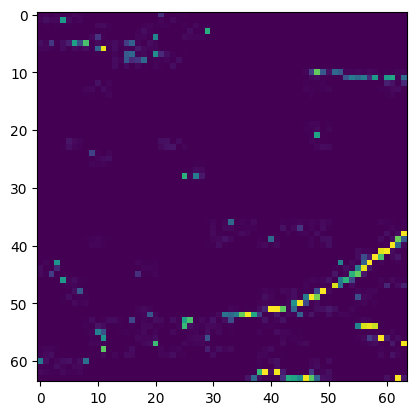

In [16]:
plt.imshow(m[5])

# UNET MODEL

In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# U-Net model using functions
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(input)
  x = BatchNormalization()(x)

  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(input)
  x = concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [22]:
inputs = Input((64, 64, 3))
s1, p1 = encoder_block(inputs, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024)

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

outputs = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 64, 64, 64)     │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 64, 64, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 32, 32, 128)    │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 16, 16, 256)    │          1,024 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 16, 16, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# COMPILING AND TRAINING THE MODEL

In [23]:
model.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [24]:
with tf.device("/device:GPU:0"):
    starting_time= time.time()
    history = model.fit(dataset, batch_size = 32, epochs = 50, verbose = 1)
    print('Total time', time.time() - starting_time)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 738ms/step - accuracy: 0.5735 - loss: 0.6432
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 689ms/step - accuracy: 0.6361 - loss: 0.4894
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 677ms/step - accuracy: 0.6495 - loss: 0.4641
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 687ms/step - accuracy: 0.6578 - loss: 0.4371
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.6599 - loss: 0.4363
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 684ms/step - accuracy: 0.6587 - loss: 0.4488
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 680ms/step - accuracy: 0.6670 - loss: 0.4285
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.6644 - loss: 0.4249
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 675ms/step - accuracy: 0.6742 - loss: 0.4066
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 676ms/step - accuracy: 0.6738 - loss: 0.4143
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - accuracy: 0.6823 - loss: 0.3900
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 83

# PREDICTION USING TEST DATASET

In [33]:
test_img_file = '/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Images/*.jpg'
test_img_files = []
for files in sorted(glob.glob(test_img_file)):
    test_img_files.append(files)
print(len(test_img_files))

2841


In [35]:
test_mask_file = '/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Masks/*.jpg'
test_mask_files = []
for files in sorted(glob.glob(test_mask_file)):
    test_mask_files.append(files)
print(len(test_mask_files))

2841


In [36]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)

In [37]:
def decode_test_images(img_filename):
    image_string = tf.io.read_file(img_filename)


    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)


    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)


    image = tf.image.resize(image, [64, 64])


    return image

In [38]:
test_dataset = test_dataset.map(decode_test_images)
#test_dataset = test_dataset.batch(16)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [39]:
test_dataset = test_dataset.batch(16)

In [40]:
im = next(iter(test_dataset))

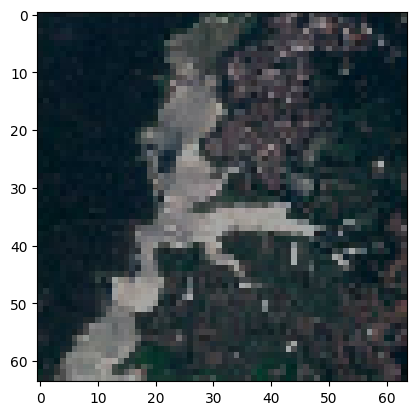

In [41]:
plt.imshow(im[1])

In [42]:
test_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [43]:
 output = model.predict(test_dataset, batch_size = 16)

178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step


In [44]:
output.shape

(2841, 64, 64, 1)

In [45]:
predictions = []
for i in  range(2683):
    pred = np.array(output[i])
    pred = (pred)
    predictions.append(pred)

In [46]:
y_test = []
for i in range(len(test_mask_files)):
    mask = tf.image.decode_jpeg(tf.io.read_file(test_mask_files[i]), channels = 1)
    mask = tf.image.resize(mask,[64, 64])
    y_test.append(mask)

In [47]:
# IoU measurement
iou_scores = []
for i in range(500):
    intersection = np.logical_and(y_test[i], predictions[i])
    union = np.logical_or(y_test[i], predictions[i])
    iou_score = np.sum(intersection)/np.sum(union)
    iou_scores.append(iou_score)
print(sum(iou_scores))
iou = sum(iou_scores)/2683
print("IoU score is : ", iou)

233.546875
IoU score is :  0.08704691576593365


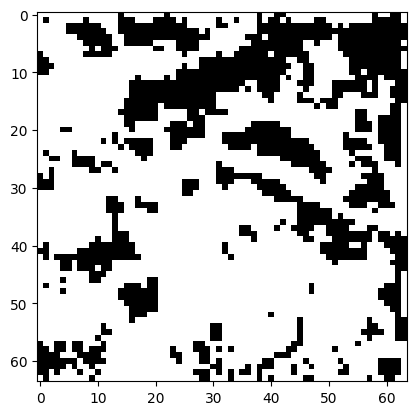

In [48]:
plt.imshow((output[0] > 0.1), cmap = 'gray')

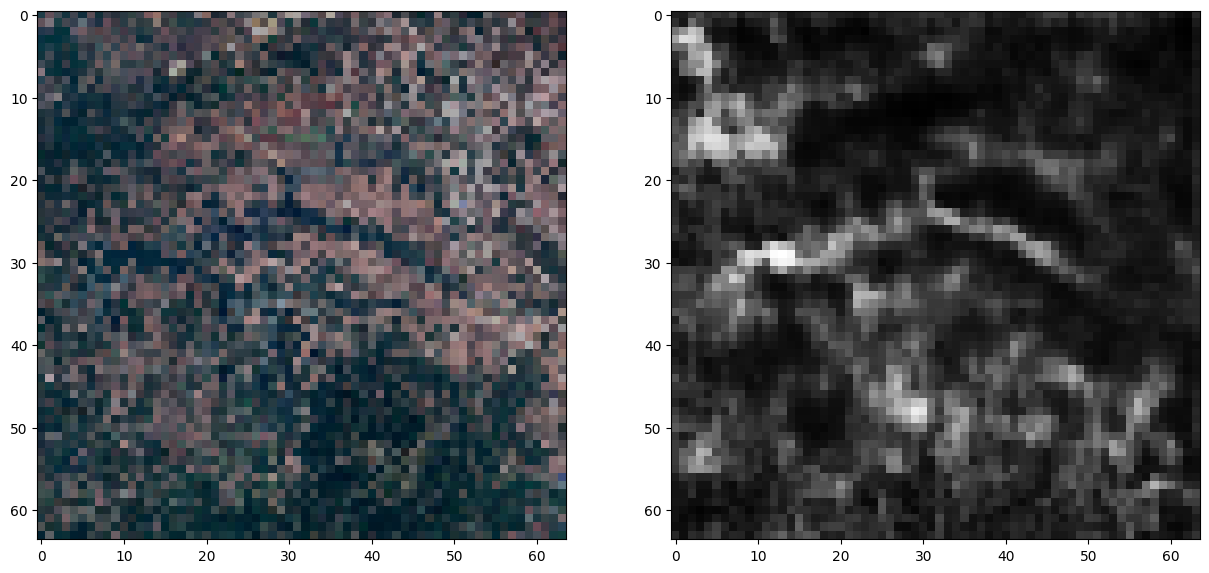

In [49]:
fig = plt.figure(figsize =(15, 15))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(im[0])
ax2 = fig.add_subplot(122)
ax2 = plt.imshow(predictions[0], cmap = 'gray')